# TVLA, DL-LA on AISy Lab data

Datasets are:

1. aes_tvla.h5: full AES encryption, traces were compressed from 220000 to 22000 samples.
2. aes_tvla_round5.h5: AES round 5, without compression.
3. aes_tvla_ttables.h5: full AES encryption, without compression.

to read the files, you can use the following code:

In [38]:
import h5py
import numpy as np
import seaborn as sns
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical

from src.data.loaders import aisy
from src.tools.cache import cache_np

from src.tools.plotter import plot_p_gradient
from src.tvla.accu import TvlaAccu

from src.data.preprocess.hw import full_states

In [39]:
from src.tvla.t import make_t_test

in_file = h5py.File(aisy.aes.tvla_ttables, "r")
TRACES = np.array(in_file['traces_group/traces'], dtype=np.int8)
TVLA_BYTE = in_file['traces_group/metadata']['tvla_byte'].astype(bool)[:, 0]
PLAINTEXT = in_file['traces_group/metadata']['plaintext'].astype(int)
CIPHERTEXT = in_file['traces_group/metadata']['ciphertext'].astype(int)
KEY = in_file['traces_group/metadata']['key'].astype(int)

sns.set_style('whitegrid')

As you can see, you have tvla_byte, which indicates if a trace has low Hamming weight in round 5 (I believe after s-box)
or simply random data. To generate a low HW state in round5, a chosen-plaintext is generated by doing a backpass in AES
encryption. But these are just details, you don't have to worry about it now.

You can split traces into groups A and B (of approx 5k traces each) by considering this tvla_byte.

In [40]:
np.min(TRACES), np.max(TRACES)

(-128, 127)

<AxesSubplot:>

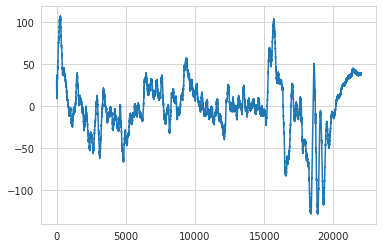

In [41]:
sns.lineplot(data=TRACES[0])

## TVLA

With 2 class evaluation. Method of the DL-LA paper.

In [42]:
# A: Low HW
A5 = TRACES[TVLA_BYTE]
# B: Random data
B5 = TRACES[np.invert(TVLA_BYTE)]

In [43]:
def random_split(x, fraction):
    """
    Splits the given array in two parts.
    - the first part is approximately of size n * (1 - fraction).
    - the second part is approximately of size n * fraction.
    """
    selection = np.random.random(len(x)) > fraction

    return x[selection], x[np.invert(selection)]

def random_divide(x):
    """
    Divides the given array in two equally sized parts.
    """
    left, right = random_split(x, .5)
    res_size = min(len(left), len(right))

    return left[:res_size], right[:res_size]

In [44]:
def mdiff(a, b):
    """
    Calculates the moment difference for all sample points,
    a predictive measure for the performance of an 1st order t-test.
    """
    def get_moment(x: np.array):
        return x.mean(axis=0, dtype=np.float128)

    a1, a2 = random_divide(a)
    _, b2 = random_divide(b)

    mdiff_in = np.abs(get_moment(a1) - get_moment(a2))
    mdiff_out = np.abs(get_moment(a1) - get_moment(b2))

    return mdiff_out - mdiff_in

MDIFF = mdiff(A5, B5)

<AxesSubplot:>

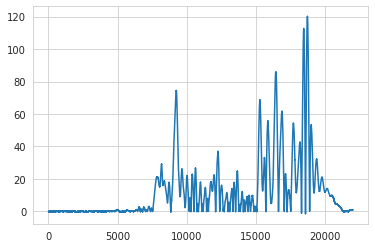

In [45]:
sns.lineplot(data=MDIFF)

In [46]:
def min_p_gradient(a, b):
    """
    Calculates the min p-gradient for the t-test of two data sets.
    """
    accumulator = TvlaAccu(a.shape[1], make_test=make_t_test)
    accumulator.add(a, b)

    return accumulator.p_gradient

P_GRADIENT_AB = cache_np('aisy/p_gradient_ab', min_p_gradient, A5, B5)
P_GRADIENT_BB = cache_np('aisy/p_gradient_bb', min_p_gradient, *random_divide(B5))

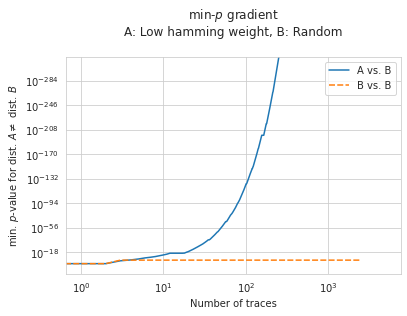

In [47]:
plot_p_gradient({"A vs. B": P_GRADIENT_AB, "B vs. B": P_GRADIENT_BB}, "A: Low hamming weight, B: Random\n")

## 2-class training

With 2 class evaluation

In [48]:
NUM_CLASSES = 2
TRACE_LEN = A5.shape[1]

def make_mlp_mini(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(TRACE_LEN,)))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=True)

    return out, mdl

def get_mini_model(args):
    return make_mlp_mini(*args, params={
        'activation':'relu',
        'optimizer': Adam(lr=0.001),
        'losses': 'categorical_crossentropy',
        'batch_size': 150,
        'epochs': 1
    })[1]

In [58]:
def z_norm(x_profiling, x_attack):
    profiling_mean, profiling_var = x_profiling.mean(axis=0), x_profiling.var(axis=0)

    def norm(x):
        return (x - profiling_mean) / profiling_var

    return norm(x_profiling), norm(x_attack)


def labelize(x, y: int, num_classes=NUM_CLASSES):
    return [to_categorical(y, num_classes),] * len(x)

def concat(a, b):
    return np.concatenate((a, b), axis=0)

def prepare_dlla(a, b):
    a_profile, a_attack = random_split(a, .2)
    b_profile, b_attack = random_split(b, .2)

    # Label traces using one-hot encoding.
    y_profiling = concat(labelize(a_profile, 0), labelize(b_profile, 1))
    y_attack = concat(labelize(a_attack, 0), labelize(b_attack, 1))

    # z-normalize traces based on Profiling mean and variance.
    x_profiling, x_attack = z_norm(concat(a_profile, b_profile), concat(a_attack, b_attack))

    # Randomize for good measure.
    ix_profiling, ix_attack = np.arange(len(x_profiling)), np.arange(len(x_attack))
    np.random.shuffle(ix_profiling)
    np.random.shuffle(ix_attack)

    return x_profiling[ix_profiling], y_profiling[ix_profiling], x_attack[ix_attack], y_attack[ix_attack]


AB_PREP = prepare_dlla(A5, B5)
MODEL_AB = get_mini_model(AB_PREP)

54/54 [==============================] - 1s 16ms/step - loss: 0.0805 - accuracy: 0.9475 - val_loss: 0.0083 - val_accuracy: 0.9985


In [59]:
BB_PREP = prepare_dlla(*random_divide(B5))
MODEL_BB = get_mini_model(BB_PREP)

27/27 [==============================] - 1s 18ms/step - loss: 0.9238 - accuracy: 0.5036 - val_loss: 0.8854 - val_accuracy: 0.4789


In [60]:
def accuracy(model: Model, x_attack, y_attack):
    prediction = model.predict(x_attack)
    correct = np.sum(prediction.argmax(axis=1) ==  y_attack.argmax(axis=1))

    return correct / len(prediction)

In [61]:
accuracy(MODEL_AB, *AB_PREP[2:])

0.9985301322880941

In [62]:
accuracy(MODEL_BB, *BB_PREP[2:])

0.478900883218842

### TODO
1. Take p-value calculator from DL-LA paper
2. Apply it to the results above, over traces.

## 9-class training

With 2 class evaluation

In [63]:
def hw_byte(plaintexts: np.array, keys: np.array, aes_round=4, target_byte=2):
    """
    Returns the hamming weight of the AES state at the given round and target byte indexes.
    """
    states = full_states(plaintexts, keys)

    return states[:, aes_round, target_byte]

HAMMING_WEIGHTS = cache_np(F'aisy/hw_r5_b3', hw_byte, PLAINTEXT, KEY)

### TODO
1. Do 9 class train, 2 class LA on HW bytes from above.